NameError: name 'landsat_post_xr' is not defined

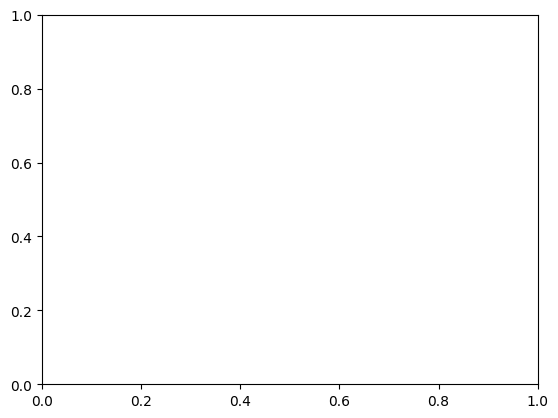

In [1]:
import os
from glob import glob

import matplotlib.pyplot as plt
import geopandas as gpd
import rasterio as rio
import xarray as xr
import rioxarray as rxr
import numpy as np
import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep
from shapely.geometry import mapping


# Download data and set working directory
data = et.data.get_data('cold-springs-fire')
os.chdir(os.path.join(et.io.HOME,
                      'earth-analytics',
                      'data'))


landsat_post_fire_path = os.path.join("cold-springs-fire",
                                      "landsat_collect",
                                      "LC080340322016072301T1-SC20180214145802",
                                      "crop")

glob(os.path.join(landsat_post_fire_path, "*"))


glob(os.path.join(landsat_post_fire_path, "*.tif"))


# Only grab bands 2 through 5
all_landsat_post_bands = glob(os.path.join(landsat_post_fire_path,
                                           "*band[2-5]*.tif"))
all_landsat_post_bands


all_landsat_post_bands.sort()
all_landsat_post_bands


def open_clean_band(band_path):
    """A function that opens a Landsat band as an (rio)xarray object

    Parameters
    ----------
    band_path : list
        A list of paths to the tif files that you wish to combine.

    Returns
    -------
    An single xarray object with the Landsat band data.

    """

    return rxr.open_rasterio(band_path, masked=True).squeeze()


    landsat_post_xr = open_clean_band(all_landsat_post_bands[0])

# Plot the data
f, ax = plt.subplots()
landsat_post_xr.plot.imshow(cmap="Greys_r",
                            ax=ax)
ax.set_title("Plot of Band 2")
ax.set_axis_off()
plt.show()

# Open up boundary extent using GeoPandas
fire_boundary_path = os.path.join("cold-springs-fire",
                                  "vector_layers",
                                  "fire-boundary-geomac",
                                  "co_cold_springs_20160711_2200_dd83.shp")

fire_boundary = gpd.read_file(fire_boundary_path)


# Get the CRS of your data
landsat_crs = es.crs_check(all_landsat_post_bands[0])

print("Landsat crs is:", landsat_crs)
print("Fire boundary crs", fire_boundary.crs)


# Reproject data to CRS of raster data
fire_boundary_utmz13 = fire_boundary.to_crs(landsat_crs)
fire_boundary_utmz13.plot()
plt.show()


landsat_post_xr_clip = rxr.open_rasterio(all_landsat_post_bands[0]).rio.clip(
    fire_boundary_utmz13.geometry,
    from_disk=True).squeeze()

# Notice the x and y data dimensions of your data have changed
landsat_post_xr_clip


# Plot the data
f, ax = plt.subplots(figsize=(10, 6))
landsat_post_xr_clip.plot.imshow(cmap="Greys_r",
                                 ax=ax)
ax.set_axis_off()
ax.set_title("Band 1 - Clipped To Your Study Area")
plt.show()


# Clean the data
valid_range = (0, 10000)
# Only run this step if a valid range tuple is provided
if valid_range:
    mask = ((landsat_post_xr_clip < valid_range[0]) | (
        landsat_post_xr_clip > valid_range[1]))
    landsat_post_xr_clip = landsat_post_xr_clip.where(
        ~xr.where(mask, True, False))


f, ax = plt.subplots()
landsat_post_xr_clip.plot(ax=ax)
ax.set_title("Band 1 plot")
ax.set_axis_off()
plt.show()


def open_clean_band(band_path, clip_extent, valid_range=None):
    """A function that opens a Landsat band as an (rio)xarray object

    Parameters
    ----------
    band_path : list
        A list of paths to the tif files that you wish to combine.

    clip_extent : geopandas geodataframe
        A geodataframe containing the clip extent of interest. NOTE: this will 
        fail if the clip extent is in a different CRS than the raster data.

    valid_range : tuple (optional)
        The min and max valid range for the data. All pixels with values outside
        of this range will be masked.

    Returns
    -------
    An single xarray object with the Landsat band data.

    """

    try:
        clip_bound = clip_extent.geometry
    except Exception as err:
        print("Oops, I need a geodataframe object for this to work.")
        print(err)

    cleaned_band = rxr.open_rasterio(band_path,
                                     masked=True).rio.clip(clip_bound,
                                                           from_disk=True).squeeze()

    # Only mask the data if a valid range tuple is provided
    if valid_range:
        mask = ((landsat_post_xr_clip < valid_range[0]) | (
            landsat_post_xr_clip > valid_range[1]))
        cleaned_band = landsat_post_xr_clip.where(
            ~xr.where(mask, True, False))

    return cleaned_band

    cleaned_band = open_clean_band(all_landsat_post_bands[0], fire_boundary_utmz13)

f, ax = plt.subplots()
cleaned_band.plot(ax=ax)
ax.set_title("Band 1 plot")
ax.set_axis_off()
plt.show()


# Open up boundary extent using GeoPandas
fire_boundary_path = os.path.join("cold-springs-fire",
                                  "vector_layers",
                                  "fire-boundary-geomac",
                                  "co_cold_springs_20160711_2200_dd83.shp")

fire_boundary = gpd.read_file(fire_boundary_path)


# Get a list of required bands - bands 2 through 5
all_landsat_post_bands = glob(os.path.join(landsat_post_fire_path,
                                           "*band[2-5]*.tif"))
all_landsat_post_bands.sort()
all_landsat_post_bands


# Reproject your vector layer
landsat_crs = es.crs_check(all_landsat_post_bands[0])

# Reproject fire boundary for clipping
fire_boundary_utmz13 = fire_boundary.to_crs(landsat_crs)


post_all_bands = []
for i, aband in enumerate(all_landsat_post_bands):
    cleaned = open_clean_band(aband, fire_boundary_utmz13)
    # This line below is only needed if you wish to stack and plot your data
    cleaned["band"] = i+1
    post_all_bands.append(cleaned)


    # OPTIONAL - Stack the data
post_fire_stack = xr.concat(post_all_bands, dim="band")
post_fire_stack

# Plot the final stacked data
post_fire_stack.plot.imshow(col="band",
                            col_wrap=2,
                            cmap="Greys_r")
plt.show()

# Plot using earthpy
band_titles = ["Blue",
               "Green",
               "Red",
               "NIR"]

ep.plot_bands(post_fire_stack,
              figsize=(11, 6),
              cols=2,
              title=band_titles,
              cbar=False)
plt.show()


# Plot array
ep.plot_rgb(post_fire_stack,
            rgb=[2, 1, 0],
            title="CIR Image Landsat Post Fire")

plt.show()


def process_bands(paths, crop_layer, stack=False):
    """
    Open, clean and crop a list of raster files using rioxarray.

    Parameters
    ----------
    paths : list
        A list of paths to raster files that could be stacked (of the same 
        resolution, crs and spatial extent).
    
    crop_layer : geodataframe
        A geodataframe containing the crop geometry that you wish to crop your
        data to.
        
    stack : boolean
        If True, return a stacked xarray object. If false will return a list
        of xarray objects.

    Returns
    -------
        Either a list of xarray objects or a stacked xarray object
    """

    all_bands = []
    for i, aband in enumerate(paths):
        cleaned = open_clean_band(aband, crop_layer)
        cleaned["band"] = i+1
        all_bands.append(cleaned)

    if stack:
        print("I'm stacking your data now.")
        return xr.concat(all_bands, dim="band")
    else:
        print("Returning a list of xarray objects.")
        return all_bands
        


# Open up boundary extent using GeoPandas
fire_boundary_path = os.path.join("cold-springs-fire",
                                  "vector_layers",
                                  "fire-boundary-geomac",
                                  "co_cold_springs_20160711_2200_dd83.shp")

fire_boundary = gpd.read_file(fire_boundary_path)

# Get a list of required bands - bands 2 through 5
all_landsat_post_bands = glob(os.path.join(landsat_post_fire_path,
                                           "*band[2-5]*.tif"))
all_landsat_post_bands.sort()

# Get CRS of landsat data and reproject fire boundary
landsat_crs = es.crs_check(all_landsat_post_bands[0])
fire_boundary_utmz13 = fire_boundary.to_crs(landsat_crs)


# Process all bands
post_fire_stack = process_bands(all_landsat_post_bands, 
                                fire_boundary_utmz13, 
                                stack=True)
post_fire_stack.shape

# Plot using earthpy
band_titles = ["Blue Band",
               "Green Band",
               "Red Band",
               "NIR Band"]

# Plot the final data
ep.plot_bands(post_fire_stack,
             cols=2,
             figsize=(10,5))
plt.suptitle("Cleaned and Cropped Landsat Bands")
plt.show()

